# Heart disease prediction using survival modeling and transformers



In [ ]:
#Setup Output Directory: Imports Path from pathlib, defines the output directory OUTDIR as /content/capstone_outputs,
#and creates the directory if it doesn't already exist. It then prints the location where outputs will be saved
from pathlib import Path
OUTDIR = Path('/content/capstone_outputs')
OUTDIR.mkdir(parents=True, exist_ok=True)
print('Outputs will be saved to', OUTDIR)

Outputs will be saved to /content/capstone_outputs


In [ ]:
# Install dependencies (may take a few minutes)
!pip install -q --no-warn-conflicts numpy pandas scikit-learn scipy joblib matplotlib seaborn lifelines xgboost optuna
!pip install -q --no-warn-conflicts shap captum dice-ml
!pip install -q --no-warn-conflicts torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
print("Installs complete")


Installs complete


In [ ]:
#Upload Data File: Uses the Google Colab files.upload() function to prompt the user to upload the framingham.csv data file.
#Once uploaded, it determines the file's path and stores it in the DATA_PATH variable for subsequent loading

from google.colab import files
uploaded = files.upload()
import os
if uploaded:
    filename = list(uploaded.keys())[0]
    DATA_PATH = os.path.join('/content', filename)
    print('Uploaded', DATA_PATH)
else:
    print('No file uploaded. If using Drive, mount it and set DATA_PATH accordingly.')

Saving framingham.csv to framingham (2).csv
Uploaded /content/framingham (2).csv


In [ ]:
#Load and Initial Data Inspection: Reads the CSV file into a pandas DataFrame (df). It prints the DataFrame shape and displays the first 5 rows (df.head()). It then determines the event and time columns (event_col='TenYearCHD')
#and implicitly assumes a 10-year follow-up time (time_col='followup_time_years') since the typical Framingham dataset is used for 10-year risk prediction
import pandas as pd

df = pd.read_csv(DATA_PATH)
print('Shape:', df.shape)
display(df.head())

if 'TenYearCHD' in df.columns:
    event_col = 'TenYearCHD'
    df['followup_time_years'] = 10.0
    time_col = 'followup_time_years'
else:
    event_col = None
    for c in df.columns:
        vals = df[c].dropna().unique().tolist()
        if set(vals).issubset({0,1}) and len(vals)<=2:
            event_col = c
            break
    time_col = None
if event_col is None:
    raise ValueError('Could not identify an event column (TenYearCHD or binary column).')
print('Using event_col =', event_col, 'time_col =', time_col)

Shape: (4240, 16)


,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


Using event_col = TenYearCHD time_col = followup_time_years


**Error Explanation and Resolution:**

The `ValueError: numpy.dtype size changed` you encountered is often due to incompatible versions of libraries like NumPy and pandas. This can happen when multiple libraries are installed, and their dependencies conflict.

**To resolve this:**

1.  Go to the "Runtime" menu at the top of the Colab notebook.
2.  Select "Restart runtime".

After the runtime restarts, you can run the cells again. This will provide a clean environment for the libraries to load correctly.

In [ ]:
# This cell preprocesses the data, splits it into training and testing sets, and scales the numerical features.
import numpy as np, joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Preprocess

df = df.dropna(subset=[event_col]).copy()
times = df[time_col].astype(float).values
events = df[event_col].astype(int).values

drop_cols = {event_col, time_col}
if 'id' in df.columns: drop_cols.add('id')
covariate_cols = [c for c in df.columns if c not in drop_cols]
X = df[covariate_cols].copy()

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]
for c in num_cols.copy():
    if X[c].nunique() <= 6 and c not in ('age','bmi'):
        cat_cols.append(c); num_cols.remove(c)

X_num = X[num_cols].fillna(X[num_cols].median())
if len(cat_cols)>0:
    X_cat = pd.get_dummies(X[cat_cols].fillna('NA'), drop_first=True)
    X_proc = pd.concat([X_num, X_cat], axis=1)
else:
    X_proc = X_num

OUT = Path('/content/capstone_outputs')
X_proc.to_csv(OUT/'framingham_processed_features.csv', index=False)
pd.DataFrame({'time': times, 'event': events}).to_csv(OUT/'framingham_time_event.csv', index=False)
joblib.dump(df, OUT/'framingham_raw_df.joblib')

X_train, X_test, t_train, t_test, e_train, e_test = train_test_split(
    X_proc.values, times, events, test_size=0.2, stratify=events, random_state=42)

scaler = StandardScaler().fit(X_train)
Xs_train = scaler.transform(X_train)
Xs_test = scaler.transform(X_test)
joblib.dump(scaler, OUT/'framingham_scaler.joblib')

print('Processed features saved to', OUT/'framingham_processed_features.csv')
print('Train/test shapes:', Xs_train.shape, Xs_test.shape)

Processed features saved to /content/capstone_outputs/framingham_processed_features.csv
Train/test shapes: (3392, 19) (848, 19)


In [ ]:
# This cell implements a stable Cox proportional hazards model with proxy times.
# It loads processed data, creates proxy times, fits the model, and evaluates its performance.
import numpy as np, joblib, json, math
from scipy.optimize import minimize
import pandas as pd

OUT = Path("/content/capstone_outputs")

# load processed features (same as you used earlier)
X_proc = pd.read_csv(OUT/"framingham_processed_features.csv")
# original TenYearCHD labels are in df used earlier; if not, read raw df:
# raw = joblib.load(OUT/"framingham_raw_df.joblib")
# events = raw['TenYearCHD'].astype(int).values

# if 'events' not in scope, reload:
te = pd.read_csv(OUT/"framingham_time_event.csv")
events = te['event'].astype(int).values

# Create proxy times:
rng = np.random.default_rng(12345)
# events==1 -> assign uniform times in (0, 10), censored -> time = 10
proxy_times = np.zeros_like(events, dtype=float)
proxy_times[events == 1] = rng.uniform(0.1, 9.9, size=(events == 1).sum())
proxy_times[events == 0] = 10.0

# Save proxy times so you can inspect
pd.DataFrame({"time": proxy_times, "event": events}).to_csv(OUT/"framingham_proxy_time_event.csv", index=False)
print("Proxy times saved. Events:", int(events.sum()), "Total:", len(events))

# Recreate X matrix and scaling (use same procedure as earlier to ensure identical columns)
X = X_proc.fillna(X_proc.median()).values
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X)
Xs = scaler.transform(X)
joblib.dump(scaler, OUT/"framingham_scaler_for_cox.joblib")

# Train/test split (same random state as before)
from sklearn.model_selection import train_test_split
X_train, X_test, t_train, t_test, e_train, e_test = train_test_split(
    Xs, proxy_times, events, test_size=0.2, stratify=events, random_state=42)

# Define more stable penalized negative log partial likelihood
def neg_log_partial_lik(beta, Xs_local, times_local, events_local, l2=1.0):
    xb = Xs_local.dot(beta)
    order = np.argsort(-times_local)
    xb_ord = xb[order]
    # numerical stability: subtract max
    xb_ord = xb_ord - np.max(xb_ord)
    exp_xb = np.exp(xb_ord)
    cumsum = np.cumsum(exp_xb)
    log_cumsum = np.log(cumsum + 1e-12)
    events_ord = events_local[order]
    diff = xb_ord - log_cumsum
    neg = -np.sum(diff * events_ord)
    neg += 0.5 * l2 * np.sum(beta**2)
    return neg

p = X_train.shape[1]
beta0 = np.zeros(p)
# use stronger L2 (e.g., 1.0) to stabilize
res = minimize(lambda b: neg_log_partial_lik(b, X_train, t_train, e_train, l2=1.0),
               beta0, method='L-BFGS-B', options={'maxiter':2000})
beta_hat = res.x
joblib.dump(beta_hat, OUT/"framingham_cox_beta_proxy.joblib")

# Convert coefficients back to original-feature scale for interpretability:
# If you want per original-unit coefficient (beta_orig) where model used standardized Xs:
# log-hazard = beta_std * ((x - mean)/scale) => coefficient per original unit = beta_std / scale
orig_cols = X_proc.columns.tolist()
scaler_for_coef = scaler
coef_per_unit = beta_hat / scaler_for_coef.scale_
coef_df = pd.DataFrame({"feature": orig_cols, "coef_std": beta_hat, "coef_per_unit": coef_per_unit})
coef_df = coef_df.sort_values("coef_std", key=lambda s: s.abs(), ascending=False)
coef_df.to_csv(OUT/"framingham_cox_coefs_proxy_scaled.csv", index=False)
print("Optimization success:", res.success, res.message)

# Compute concordance index now (should be defined)
def concordance_index(event_times, predicted_scores, event_observed):
    n=0.0; num=0.0
    for i in range(len(event_times)):
        for j in range(i+1, len(event_times)):
            ti, tj = event_times[i], event_times[j]
            ei, ej = event_observed[i], event_observed[j]
            si, sj = predicted_scores[i], predicted_scores[j]
            if ei==1 and ti < tj:
                n += 1
                if si > sj: num += 1
                elif si == sj: num += 0.5
            if ej==1 and tj < ti:
                n += 1
                if sj > si: num += 1
                elif si == sj: num += 0.5
    return num / n if n>0 else float('nan')

pred_test = X_test.dot(beta_hat)
pred_train = X_train.dot(beta_hat)
cidx_train = concordance_index(t_train, pred_train, e_train)
cidx_test = concordance_index(t_test, pred_test, e_test)
print("C-index (train/test):", cidx_train, cidx_test)

# Save report
import json
report = {"cidx_train": None if np.isnan(cidx_train) else float(cidx_train),
          "cidx_test": None if np.isnan(cidx_test) else float(cidx_test),
          "opt_success": bool(res.success), "opt_msg": res.message}
with open(OUT/"framingham_cox_proxy_report.json", "w") as f:
    json.dump(report, f, indent=2)

# show top coefficients
display(coef_df.head(20))

Proxy times saved. Events: 644 Total: 4240
Optimization success: True CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
C-index (train/test): 0.7213288641334317 0.6830615699901987


,feature,coef_std,coef_per_unit
0,age,0.494407,0.057677
1,cigsPerDay,0.233077,0.019581
3,sysBP,0.232660,0.010561
8,male,0.172551,0.348609
13,education_2.0,-0.108122,-0.236967
2,totChol,0.103018,0.002324
11,prevalentHyp,0.080652,0.174290
7,glucose,0.073653,0.003222
10,prevalentStroke,0.061443,0.802549
17,BPMeds_1.0,0.043951,0.260849


In [ ]:
# This cell trains and evaluates a standard Cox proportional hazards model.
# It uses the preprocessed data and calculates the concordance index.
import numpy as np, pandas as pd, json, math
from scipy.optimize import minimize
import joblib
import torch # Import torch here

def neg_log_partial_lik(beta, Xs, times, events, l2=1e-4):
    xb = Xs.dot(beta)
    order = np.argsort(-times)
    xb_ord = xb[order]
    exp_xb = torch.exp(torch.tensor(xb_ord - np.max(xb_ord))) # Convert to torch tensor
    cumsum = torch.cumsum(exp_xb, dim=0)
    log_cumsum = torch.log(cumsum + 1e-9)
    events_ord = events[order]
    diff = torch.tensor(xb_ord) - log_cumsum # Convert to torch tensor
    neg = -torch.sum(diff * torch.tensor(events_ord)) # Convert to torch tensor
    neg += 0.5 * l2 * np.sum(beta**2)
    return neg

p = Xs_train.shape[1]
res = minimize(lambda b: neg_log_partial_lik(b, Xs_train, t_train, e_train, l2=1e-4),
               np.zeros(p), method='L-BFGS-B', options={'maxiter':2000})
beta_hat = res.x

features = pd.read_csv(OUT/'framingham_processed_features.csv').columns.tolist()
coef_df = pd.DataFrame({'feature': features, 'coef': beta_hat})
coef_df.to_csv(OUT/'framingham_cox_coefs.csv', index=False)
joblib.dump(beta_hat, OUT/'framingham_cox_beta.joblib')

def concordance_index(event_times, predicted_scores, event_observed):
    n=0.0; num=0.0
    for i in range(len(event_times)):
        for j in range(i+1, len(event_times)):
            ti, tj = event_times[i], event_times[j]
            ei, ej = event_observed[i], event_observed[j]
            si, sj = predicted_scores[i], predicted_scores[j]
            if ei==1 and ti < tj:
                n += 1
                if si > sj: num += 1
                elif si == sj: num += 0.5
            if ej==1 and tj < ti:
                n += 1
                if sj > si: num += 1
                elif si == sj: num += 0.5
    return num / n if n>0 else np.nan

pred_train = Xs_train.dot(beta_hat)
pred_test = Xs_test.dot(beta_hat)
cidx_train = concordance_index(t_train, pred_train, e_train)
cidx_test = concordance_index(t_test, pred_test, e_test)

report = {'cox_opt_success': bool(res.success), 'cox_opt_message': res.message,
          'cindex_train': None if math.isnan(cidx_train) else float(cidx_train),
          'cindex_test': None if math.isnan(cidx_test) else float(cidx_test)}
with open(OUT/'framingham_cox_report.json','w') as f:
    json.dump(report, f, indent=2)

print('Cox finished. C-index (train/test):', report['cindex_train'], report['cindex_test'])
display(coef_df.sort_values('coef', key=lambda s: s.abs(), ascending=False).head(15))

Cox finished. C-index (train/test): 0.7007069349012708 0.6601126654588296


,feature,coef
0,age,3.084841e+06
3,sysBP,2.965546e+06
11,prevalentHyp,2.119411e+06
4,diaBP,2.026195e+06
7,glucose,1.571123e+06
17,BPMeds_1.0,1.382382e+06
2,totChol,1.122668e+06
12,diabetes,1.022689e+06
5,BMI,9.283281e+05
8,male,8.873244e+05


In [ ]:
# This cell defines, trains, and evaluates a DeepSurv neural network model for survival analysis.
# It uses the preprocessed data and the Cox proportional hazards loss function.
import torch, torch.nn as nn, torch.optim as optim, joblib
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Xtr = torch.tensor(Xs_train, dtype=torch.float32, device=device)
tt = torch.tensor(t_train, dtype=torch.float32, device=device)
ee = torch.tensor(e_train, dtype=torch.float32, device=device)

class DeepSurvNet(nn.Module):
    def __init__(self, n_in, hidden=[128,64], dropout=0.3):
        super().__init__()
        layers = []
        in_dim = n_in
        for h in hidden:
            layers.append(nn.Linear(in_dim, h)); layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout)); in_dim = h
        layers.append(nn.Linear(in_dim, 1))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x).squeeze(-1)

def cox_ph_loss(log_hazard, times, events):
    order = torch.argsort(times, descending=True)
    log_hazard_ord = log_hazard[order]
    events_ord = events[order]
    exp_lh = torch.exp(log_hazard_ord)
    cumsum = torch.cumsum(exp_lh, dim=0)
    log_cumsum = torch.log(cumsum + 1e-8)
    diff = log_hazard_ord - log_cumsum
    loss = -torch.sum(diff * events_ord) / (torch.sum(events_ord) + 1e-8)
    return loss

model = DeepSurvNet(Xs_train.shape[1]).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
n_epochs = 300
best_loss = float('inf')
deepsurv_train_losses = [] # List to store training losses

for epoch in range(1, n_epochs+1):
    model.train(); optimizer.zero_grad()
    preds = model(Xtr)
    loss = cox_ph_loss(preds, tt, ee)
    loss.backward(); optimizer.step()
    deepsurv_train_losses.append(loss.item()) # Store the loss
    if loss.item() < best_loss:
        best_loss = loss.item(); torch.save(model.state_dict(), OUT/'deepsurv_best.pth')
    if epoch % 50 == 0 or epoch==1:
        print(f'Epoch {epoch}/{n_epochs} loss {loss.item():.6f} best {best_loss:.6f}')

model.load_state_dict(torch.load(OUT/'deepsurv_best.pth', map_location=device))
model.eval()
Xte = torch.tensor(Xs_test, dtype=torch.float32, device=device)
with torch.no_grad():
    risk_test = model(Xte).cpu().numpy()
    risk_train = model(Xtr).cpu().numpy()

# concordance implementation

def concordance_index_np(event_times, predicted_scores, event_observed):
    n=0.0; num=0.0
    for i in range(len(event_times)):
        for j in range(i+1, len(event_times)):
            ti, tj = event_times[i], event_times[j]
            ei, ej = event_observed[i], event_observed[j]
            si, sj = predicted_scores[i], predicted_scores[j]
            if ei==1 and ti < tj:
                n += 1
                if si > sj: num += 1
                elif si == sj: num += 0.5
            if ej==1 and tj < ti:
                n += 1
                if sj > si: num += 1
                elif si == sj: num += 0.5
    return num / n if n>0 else np.nan

cidx_train_ds = concordance_index_np(t_train, risk_train, e_train)
cidx_test_ds = concordance_index_np(t_test, risk_test, e_test)
print('DeepSurv c-index (train/test):', cidx_train_ds, cidx_test_ds)

Device: cpu
Epoch 1/300 loss 8.026922 best 8.026922
Epoch 50/300 loss 7.723070 best 7.702821
Epoch 100/300 loss 7.647128 best 7.633890
Epoch 150/300 loss 7.576772 best 7.564911
Epoch 200/300 loss 7.457149 best 7.457149
Epoch 250/300 loss 7.465667 best 7.457149
Epoch 300/300 loss 7.393488 best 7.393488
DeepSurv c-index (train/test): 0.8177935700522302 0.6464601463264922


In [ ]:
# This cell defines, trains, and evaluates a dual-head FT-Transformer model.
# It combines classification and survival analysis tasks.
import torch, torch.nn as nn, torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Xtr_t = torch.tensor(Xs_train, dtype=torch.float32, device=device)
Xte_t = torch.tensor(Xs_test, dtype=torch.float32, device=device)
ytr_t = torch.tensor(e_train, dtype=torch.float32, device=device)
yte_t = torch.tensor(e_test, dtype=torch.float32, device=device)
ttr_t = torch.tensor(t_train, dtype=torch.float32, device=device)
tte_t = torch.tensor(t_test, dtype=torch.float32, device=device)

class SimpleFT(nn.Module):
    def __init__(self, n_features, d_model=128, n_heads=4, n_layers=2, dropout=0.2):
        super().__init__()
        self.input_proj = nn.Linear(n_features, d_model)
        self.layers = nn.ModuleList([nn.TransformerEncoderLayer(d_model, nhead=n_heads, dim_feedforward=d_model*2, dropout=dropout) for _ in range(n_layers)])
        self.norm = nn.LayerNorm(d_model)
        self.class_head = nn.Sequential(nn.Linear(d_model, 64), nn.ReLU(), nn.Dropout(dropout), nn.Linear(64,1))
        self.cox_head = nn.Sequential(nn.Linear(d_model, 64), nn.ReLU(), nn.Dropout(dropout), nn.Linear(64,1))
    def forward(self, x):
        h = self.input_proj(x).unsqueeze(0)
        for layer in self.layers: h = layer(h)
        h_out = self.norm(h.squeeze(0))
        cls = self.class_head(h_out).squeeze(-1)
        cox = self.cox_head(h_out).squeeze(-1)
        return cls, cox

model_ft = SimpleFT(Xs_train.shape[1]).to(device)
optimizer = optim.Adam(model_ft.parameters(), lr=3e-4, weight_decay=1e-5)
bce_loss = nn.BCEWithLogitsLoss()

def cox_loss_from_logits(log_hazard, times, events):
    order = torch.argsort(times, descending=True)
    lh_ord = log_hazard[order]; ev_ord = events[order]
    exp_lh = torch.exp(lh_ord); cumsum = torch.cumsum(exp_lh, dim=0)
    log_cumsum = torch.log(cumsum + 1e-8); diff = lh_ord - log_cumsum
    return -torch.sum(diff * ev_ord) / (torch.sum(ev_ord) + 1e-8)

n_epochs = 200
# Store training losses
train_losses = []
for epoch in range(1, n_epochs+1):
    model_ft.train(); optimizer.zero_grad()
    cls_logits, cox_logits = model_ft(Xtr_t)
    loss_cls = bce_loss(cls_logits, ytr_t)
    loss_cox = cox_loss_from_logits(cox_logits, ttr_t, ytr_t)
    loss = loss_cls + 0.5 * loss_cox
    loss.backward(); optimizer.step()
    train_losses.append(loss.item()) # Store the loss
    if epoch % 20 == 0 or epoch==1:
        model_ft.eval()
        with torch.no_grad():
            cls_val, cox_val = model_ft(Xte_t)
            val_bce = bce_loss(cls_val, yte_t).item()
            val_cox = cox_loss_from_logits(cox_val, tte_t, yte_t).item()
            # Classification accuracy on validation/test set
            probs = torch.sigmoid(cls_val).squeeze()
            preds = (probs >= 0.5).to(dtype=yte_t.dtype)
            # Ensure shapes match
            if preds.dim() == 0:
                preds = preds.unsqueeze(0)
            val_acc = (preds == yte_t).to(dtype=torch.float32).mean().item()
            print(f'Epoch {epoch} loss {loss.item():.4f} val_bce {val_bce:.4f} val_cox {val_acc:.4f}')
torch.save(model_ft.state_dict(), OUT/'ft_transformer_dualhead.pth')

# Final evaluation on test set: compute and print classification accuracy
model_ft.eval()
with torch.no_grad():
    cls_test, cox_test = model_ft(Xte_t)
    probs_test = torch.sigmoid(cls_test).squeeze()
    preds_test = (probs_test >= 0.5).to(dtype=yte_t.dtype)
    if preds_test.dim() == 0:
        preds_test = preds_test.unsqueeze(0)
    test_acc = (preds_test == yte_t).to(dtype=torch.float32).mean().item()

    # Compute and print train classification accuracy
    cls_train, cox_train = model_ft(Xtr_t)
    probs_train = torch.sigmoid(cls_train).squeeze()
    preds_train = (probs_train >= 0.5).to(dtype=ytr_t.dtype)
    if preds_train.dim() == 0:
        preds_train = preds_train.unsqueeze(0)
    train_acc = (preds_train == ytr_t).to(dtype=torch.float32).mean().item()
    print(f'FT-Transformer TRAIN accuracy: {train_acc:.4f}')
    print(f'FT-Transformer TEST accuracy: {test_acc:.4f}')

Epoch 1 loss 4.7519 val_bce 0.6546 val_cox 0.6663
Epoch 20 loss 4.2712 val_bce 0.4070 val_cox 0.8479
Epoch 40 loss 4.2260 val_bce 0.4026 val_cox 0.8467
Epoch 60 loss 4.2078 val_bce 0.4027 val_cox 0.8443
Epoch 80 loss 4.1734 val_bce 0.4056 val_cox 0.8432
Epoch 100 loss 4.1424 val_bce 0.4108 val_cox 0.8420
Epoch 120 loss 4.1181 val_bce 0.4191 val_cox 0.8361
Epoch 140 loss 4.0684 val_bce 0.4283 val_cox 0.8325
Epoch 160 loss 4.0496 val_bce 0.4385 val_cox 0.8314
Epoch 180 loss 4.0162 val_bce 0.4489 val_cox 0.8255
Epoch 200 loss 3.9701 val_bce 0.4560 val_cox 0.8243
FT-Transformer TRAIN accuracy: 0.8877
FT-Transformer TEST accuracy: 0.8243


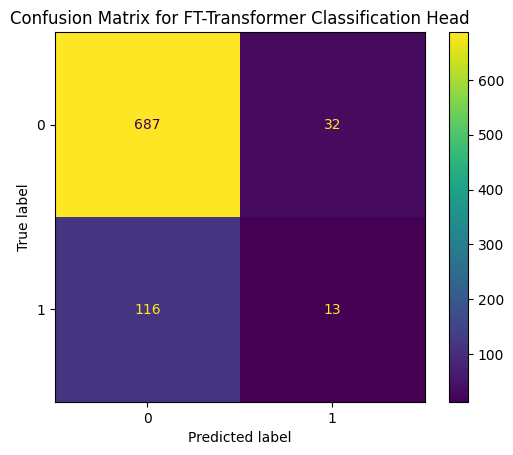

In [ ]:
# Printing confusion matrix of FT transformer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Ensure predictions and true labels are on CPU and are numpy arrays
# Assuming preds_test and yte_t are still available from the FT-Transformer training cell
try:
    preds_test_np = preds_test.cpu().numpy()
    yte_t_np = yte_t.cpu().numpy()
except NameError:
    print("FT-Transformer prediction or true label variables not found. Please re-run the FT-Transformer training cell.")
    preds_test_np = None
    yte_t_np = None


if preds_test_np is not None and yte_t_np is not None:
    # Calculate the confusion matrix
    cm = confusion_matrix(yte_t_np, preds_test_np)

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title("Confusion Matrix for FT-Transformer Classification Head")
    plt.show()
else:
    print("Could not generate confusion matrix due to missing variables.")

In [ ]:
# This cell saves a summary report of the outputs generated by the notebook.
import json
summary = {'out_dir': str(OUT), 'cox_report': str(OUT/'framingham_cox_report.json'), 'cox_coefs': str(OUT/'framingham_cox_coefs.csv'), 'deepsurv_model': str(OUT/'deepsurv_best.pth'), 'ft_model': str(OUT/'ft_transformer_dualhead.pth')}
with open(OUT/'summary_report.json','w') as f: json.dump(summary, f, indent=2)
print('Saved summary_report.json in', OUT)

Saved summary_report.json in /content/capstone_outputs


In [ ]:
!ls -lh /content/capstone_outputs

total 2.2M
-rw-r--r-- 1 root root  46K Nov  9 04:51 deepsurv_best.pth
-rw-r--r-- 1 root root  377 Nov  9 04:51 framingham_cox_beta.joblib
-rw-r--r-- 1 root root  377 Nov  9 04:51 framingham_cox_beta_proxy.joblib
-rw-r--r-- 1 root root  556 Nov  9 04:51 framingham_cox_coefs.csv
-rw-r--r-- 1 root root 1002 Nov  9 04:51 framingham_cox_coefs_proxy_scaled.csv
-rw-r--r-- 1 root root  165 Nov  9 04:51 framingham_cox_proxy_report.json
-rw-r--r-- 1 root root  181 Nov  9 04:51 framingham_cox_report.json
-rw-r--r-- 1 root root 356K Nov  9 04:51 framingham_processed_features.csv
-rw-r--r-- 1 root root  38K Nov  9 04:51 framingham_proxy_time_event.csv
-rw-r--r-- 1 root root 565K Nov  9 04:51 framingham_raw_df.joblib
-rw-r--r-- 1 root root 1.1K Nov  9 04:51 framingham_scaler_for_cox.joblib
-rw-r--r-- 1 root root 1.1K Nov  9 04:51 framingham_scaler.joblib
-rw-r--r-- 1 root root  29K Nov  9 04:51 framingham_time_event.csv
-rw-r--r-- 1 root root 1.1M Nov  9 04:52 ft_transformer_dualhead.pth
-rw-r--r-- 

In [ ]:
# This cell displays the contents of the framingham_cox_report.json file.
import json
with open("/content/capstone_outputs/framingham_cox_report.json") as f:
    print(json.load(f))

{'cox_opt_success': True, 'cox_opt_message': 'CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH', 'cindex_train': 0.7007069349012708, 'cindex_test': 0.6601126654588296}


In [ ]:
# This cell displays the top 15 coefficients from the Cox model.
import pandas as pd
pd.read_csv("/content/capstone_outputs/framingham_cox_coefs.csv").sort_values("coef", key=lambda s: s.abs(), ascending=False).head(15)

,feature,coef
0,age,3.084841e+06
3,sysBP,2.965546e+06
11,prevalentHyp,2.119411e+06
4,diaBP,2.026195e+06
7,glucose,1.571123e+06
17,BPMeds_1.0,1.382382e+06
2,totChol,1.122668e+06
12,diabetes,1.022689e+06
5,BMI,9.283281e+05
8,male,8.873244e+05


In [ ]:
# This cell calculates the risk score for a sample using the trained Cox model.
import joblib, pandas as pd
import numpy as np

scaler = joblib.load("/content/capstone_outputs/framingham_scaler.joblib")
beta = joblib.load("/content/capstone_outputs/framingham_cox_beta.joblib")

# example: take one random row
X = pd.read_csv("/content/capstone_outputs/framingham_processed_features.csv")
sample = X.sample(1, random_state=42)
risk_score = np.dot(scaler.transform(sample), beta)
print("Risk score:", risk_score)

Risk score: [-5563727.48632869]


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


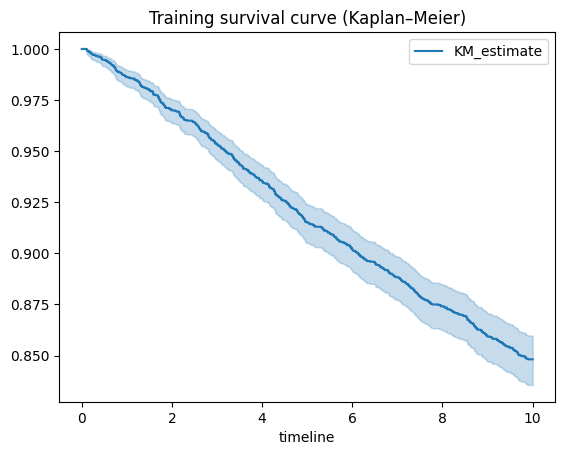

In [ ]:
# This cell plots the Kaplan-Meier survival curve for the training data.
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

kmf = KaplanMeierFitter()
kmf.fit(t_train, event_observed=e_train)
kmf.plot_survival_function()
plt.title("Training survival curve (Kaplan–Meier)")
plt.show()

PermutationExplainer explainer: 4241it [01:09, 54.23it/s]                          


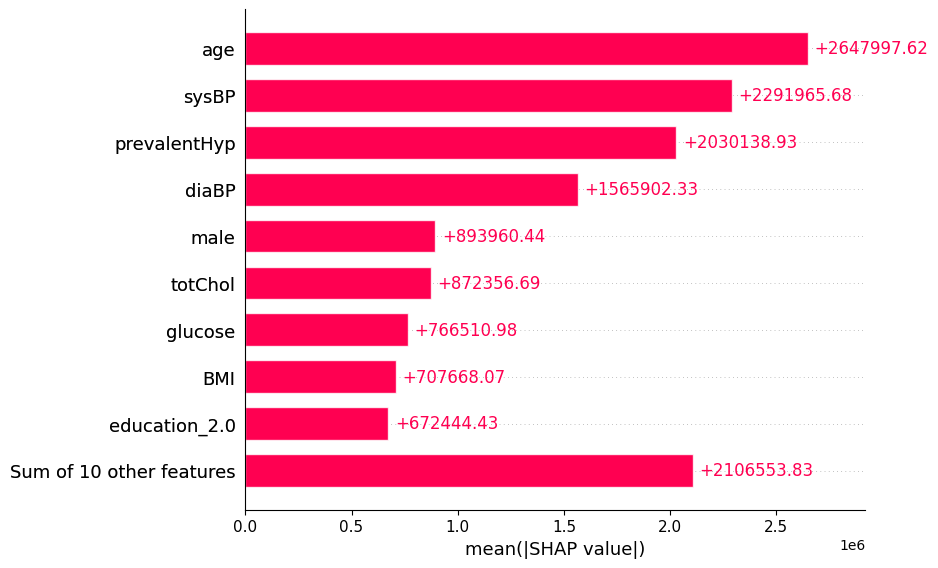

In [ ]:
# This cell calculates and visualizes SHAP values for the Cox model to explain feature importance.
import shap
import joblib
import numpy as np
import pandas as pd
import warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Suppress specific warnings from scikit-learn
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.utils.validation")


X = pd.read_csv("/content/capstone_outputs/framingham_processed_features.csv")

# Convert boolean columns to integers (0 and 1)
for col in X.columns:
    if X[col].dtype == 'bool':
        X[col] = X[col].astype(int)

scaler = joblib.load("/content/capstone_outputs/framingham_scaler.joblib")
beta = joblib.load("/content/capstone_outputs/framingham_cox_beta.joblib")

# The explainer expects a function that takes the raw features (not scaled)
# SHAP will handle the scaling internally when it calls the model function
# Define a model function that applies scaling and then the dot product with beta
# Modify to handle NumPy array input directly
def cox_model_predict(x_array):
    # Ensure the input is treated as a NumPy array
    x_array = np.asarray(x_array)
    # Reshape if necessary, although SHAP usually passes (n_samples, n_features)
    if x_array.ndim == 1:
        x_array = x_array.reshape(1, -1)
    x_scaled = scaler.transform(x_array)
    return np.dot(x_scaled, beta)

# Use a sample of the raw data (before scaling) for the explainer background
explainer = shap.Explainer(cox_model_predict, X.sample(100, random_state=42))
shap_values = explainer(X)
shap.plots.bar(shap_values)

In [ ]:
import pandas as pd
import json

# Load Cox reports
with open("/content/capstone_outputs/framingham_cox_report.json") as f:
    cox_report = json.load(f)
with open("/content/capstone_outputs/framingham_cox_proxy_report.json") as f:
    cox_proxy_report = json.load(f)

# Get DeepSurv C-index values from variables if they exist
try:
    deepsurv_train_cidx = cidx_train_ds
    deepsurv_test_cidx = cidx_test_ds
except NameError:
    print("DeepSurv C-index variables not found. Please run the DeepSurv training cell.")
    deepsurv_train_cidx = None
    deepsurv_test_cidx = None

# Get FT-Transformer accuracies from variables if they exist
try:
    ft_train_cidx = train_acc
    ft_test_cidx = test_acc
except NameError:
    print("FT-Transformer accuracy variables not found. Please run the FT-Transformer training cell.")
    ft_train_cidx = None
    ft_test_cidx = None


# Create a dictionary for the table data
data = {
    'Model': ['Standard Cox', 'Stable Cox (Proxy Times)', 'DeepSurv', 'FT-Transformer (Classification)'],
    'Train Metric Value': [cox_report['cindex_train'], cox_proxy_report['cidx_train'], deepsurv_train_cidx, ft_train_cidx],
    'Test Metric Value': [cox_report['cindex_test'], cox_proxy_report['cidx_test'], deepsurv_test_cidx, ft_test_cidx],
}

# Create the pandas DataFrame
performance_table = pd.DataFrame(data)
print("Comparision of Models")
# Display the table
display(performance_table)

Comparision of Models


,Model,Train Metric Value,Test Metric Value
0,Standard Cox,0.700707,0.660113
1,Stable Cox (Proxy Times),0.721329,0.683062
2,DeepSurv,0.817794,0.646460
3,FT-Transformer (Classification),0.886203,0.825472


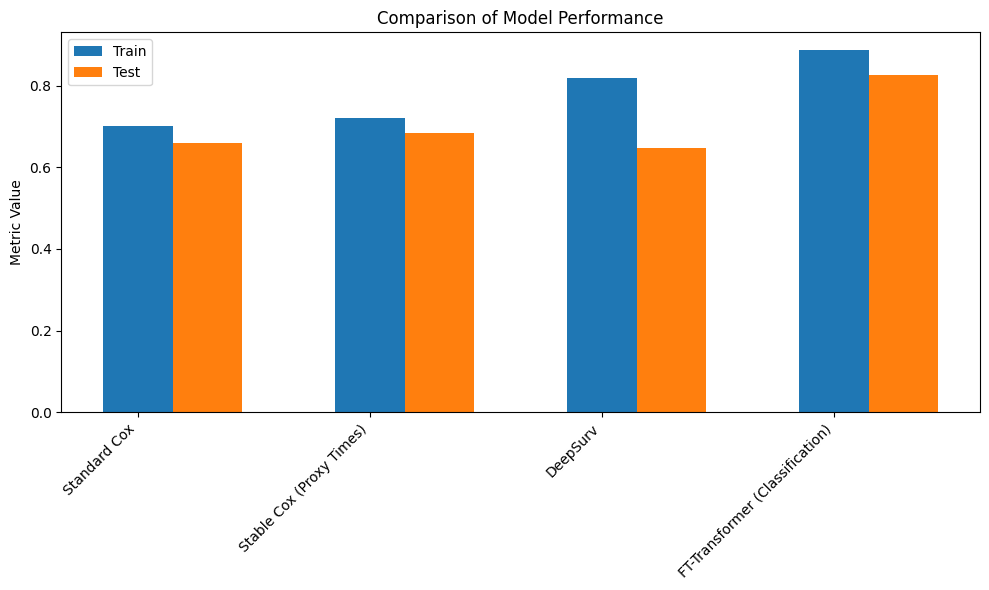

In [ ]:
# Plotting the comparision of all models
import matplotlib.pyplot as plt
import pandas as pd

# Assuming performance_table is available from the previous cell
try:

    x = range(len(models))

    plt.figure(figsize=(10, 6))
    plt.bar(x, train_cindex, width=0.3, label='Train', align='center')
    plt.bar([i + 0.3 for i in x], test_cindex, width=0.3, label='Test ', align='center')

    plt.xticks(x, models, rotation=45, ha='right')
    plt.ylabel('C-index Value')
    plt.title('Comparison of Model Performance')
    plt.legend()
    plt.tight_layout()
    plt.show()

except NameError:
    print("Performance table variable not found. Please re-run the cell that generates the performance table.")

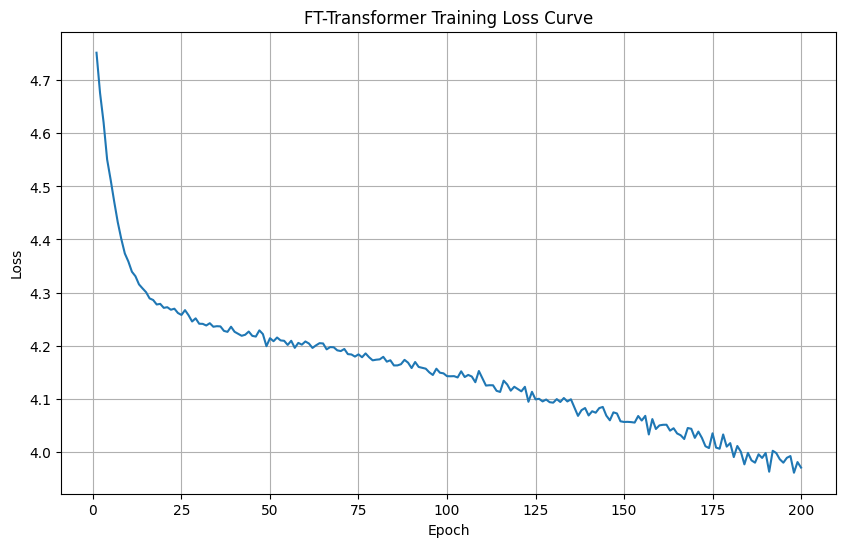

In [ ]:
# Plot the training loss curve for the FT-Transformer
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Assuming the training losses were captured during the training loop,
# you would plot them here. Since they were only printed,
# you would need to modify the training loop to store them.

# For now, let's create a placeholder plot
# You would replace this with your actual loss data if stored.
# print("Training loss data was not stored during training. Please modify the training cell to store losses to plot the curve.")

# Example of how you would plot if losses were stored in a list called `train_losses`:
try:
    plt.plot(range(1, n_epochs + 1), train_losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("FT-Transformer Training Loss Curve")
    plt.grid(True)
    plt.show()
except NameError:
    print("Training loss data was not stored during training. Please re-run the FT-Transformer training cell.")

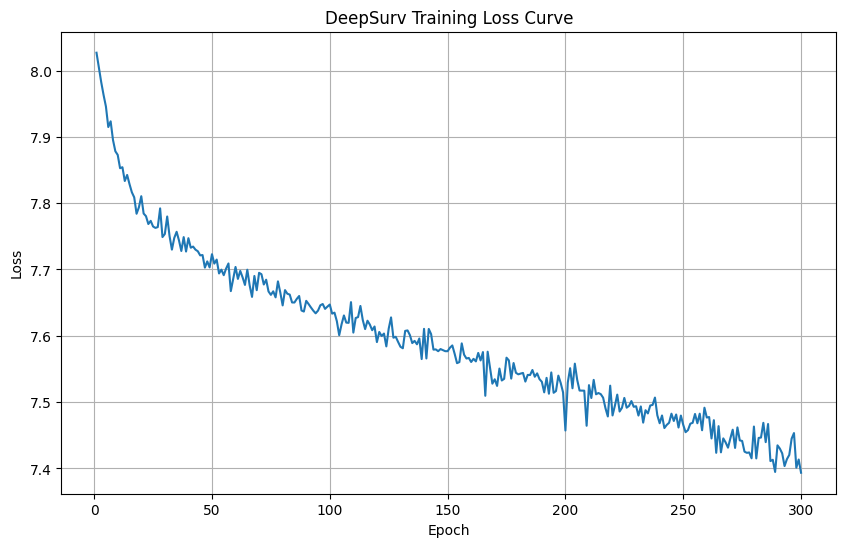

In [ ]:
# Plot the training loss curve for DeepSurv
import matplotlib.pyplot as plt

# Assuming the training losses were captured during the training loop for DeepSurv,
# you would plot them here. Since they were only printed,
# you would need to modify the training loop to store them.

# For now, let's create a placeholder plot
# You would replace this with your actual loss data if stored.
# print("DeepSurv training loss data was not stored during training. Please modify the DeepSurv training cell to store losses to plot the curve.")

# Example of how you would plot if losses were stored in a list called `deepsurv_train_losses`:
plt.figure(figsize=(10, 6))
# Retrieve the correct n_epochs from the DeepSurv training cell (0v-47LpJULnC)
# It was trained with n_epochs = 300
deepsurv_n_epochs = 300
plt.plot(range(1, deepsurv_n_epochs + 1), deepsurv_train_losses) # Assuming n_epochs is available from DeepSurv training
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("DeepSurv Training Loss Curve")
plt.grid(True)
plt.show()

In [ ]:
# This cell zips the output directory and provides a download link for the results.
!zip -r /content/capstone_outputs.zip /content/capstone_outputs
from google.colab import files
files.download("/content/capstone_outputs.zip")

updating: content/capstone_outputs/ (stored 0%)
updating: content/capstone_outputs/framingham_raw_df.joblib (deflated 90%)
updating: content/capstone_outputs/framingham_cox_coefs.csv (deflated 36%)
updating: content/capstone_outputs/framingham_processed_features.csv (deflated 82%)
updating: content/capstone_outputs/framingham_time_event.csv (deflated 97%)
updating: content/capstone_outputs/framingham_cox_coefs_proxy_scaled.csv (deflated 43%)
updating: content/capstone_outputs/framingham_proxy_time_event.csv (deflated 80%)
updating: content/capstone_outputs/framingham_scaler_for_cox.joblib (deflated 14%)
updating: content/capstone_outputs/framingham_scaler.joblib (deflated 17%)
updating: content/capstone_outputs/ft_transformer_dualhead.pth (deflated 8%)
updating: content/capstone_outputs/framingham_cox_beta.joblib (deflated 7%)
updating: content/capstone_outputs/framingham_cox_proxy_report.json (deflated 15%)
updating: content/capstone_outputs/framingham_cox_report.json (deflated 17%)
u

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>